Tutorial Code from Tensorflow
Link: https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

Downloading and setting up the data

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

68606236/68606236 [==============================] - 4s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Path to the dataset

In [3]:
print(path_to_zip)

/root/.keras/datasets/cats_and_dogs.zip


Visualization

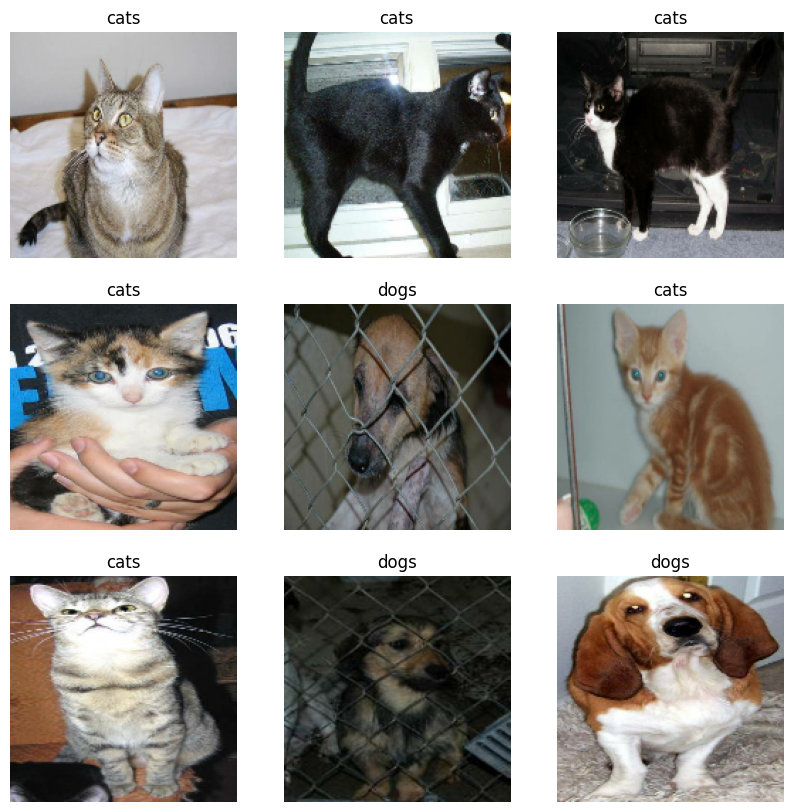

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Separating Test data from Validation

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print(f'Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_dataset)}')

Number of validation batches: 26
Number of test batches: 6


Prefetch data to improve performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

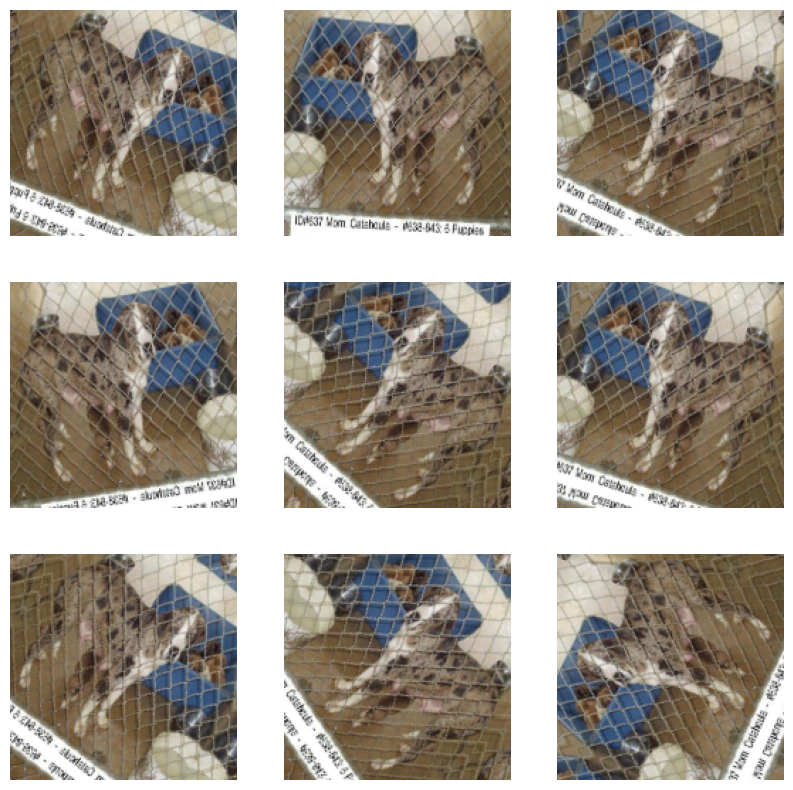

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Preprocessing data according to the model

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Loading the mobile_net_v2 model with only the lower convolution layers

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


Testing what the output of the feature extractor / lower convolution layers is. They are 5x5x1280 with 32 as the batch size as set in the beginning

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Freeze the convolution layers

In [13]:
base_model.trainable = False

Architecture of the Model

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

Does a Max Pool over the 5x5 part. Thus only keeping a 1280 size vector per image from the channels

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Adding one Dense layer to classify

In [16]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
print(prediction_batch)

tf.Tensor(
[[0.66832405]
 [0.8478641 ]
 [0.8383135 ]
 [0.6120668 ]
 [0.8119367 ]
 [0.66386366]
 [0.65044016]
 [0.7572693 ]
 [0.35638055]
 [0.6388448 ]
 [0.7627666 ]
 [0.9191323 ]
 [0.59215075]
 [0.84553957]
 [0.7274096 ]
 [0.6567623 ]
 [0.7937083 ]
 [0.74050635]
 [0.8023659 ]
 [0.87254524]
 [0.65593475]
 [0.74394983]
 [0.3490097 ]
 [0.7044038 ]
 [0.61672217]
 [0.59218496]
 [0.86578375]
 [0.7933992 ]
 [0.8895353 ]
 [0.57313997]
 [0.8794425 ]
 [0.42442244]], shape=(32, 1), dtype=float32)


The final model using data augmentation, preprocessing, the convolution layers, the averaging layer and the final dense layer

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

The 2 is there because of model.trainable_variables being a 2d matrix with dimenstion (2, something) where the 2 signifies the weights and biases

In [20]:
len(model.trainable_variables)

2

So, as normally expected, 1280 weights and 1 bias term since there is only one dense layer

In [21]:
len(list(model.trainable_variables[0])), len(list(model.trainable_variables[1]))

(1280, 1)

Reduced the learning rate since we are Fine Tuning a model. And since the output is from [-1,1] for binary classification, we are using BinaryCrossentropy and BinaryAccuracy

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [23]:
initial_epochs = 10
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 12s 86ms/step - loss: 0.6696 - accuracy: 0.6205 - val_loss: 0.4966 - val_accuracy: 0.7847
Epoch 2/10
63/63 [==============================] - 4s 52ms/step - loss: 0.5109 - accuracy: 0.7560 - val_loss: 0.3619 - val_accuracy: 0.8973
Epoch 3/10
63/63 [==============================] - 5s 64ms/step - loss: 0.4196 - accuracy: 0.8240 - val_loss: 0.2872 - val_accuracy: 0.9270
Epoch 4/10
63/63 [==============================] - 3s 52ms/step - loss: 0.3467 - accuracy: 0.8635 - val_loss: 0.2376 - val_accuracy: 0.9418
Epoch 5/10
63/63 [==============================] - 4s 53ms/step - loss: 0.2992 - accuracy: 0.8795 - val_loss: 0.2020 - val_accuracy: 0.9567
Epoch 6/10
63/63 [==============================] - 5s 78ms/step - loss: 0.2745 - accuracy: 0.9000 - val_loss: 0.1734 - val_accuracy: 0.9616
Epoch 7/10
63/63 [==============================] - 4s 52ms/step - loss: 0.2627 - accuracy: 0.9000 - val_loss: 0.1550 - val_accuracy: 0.9691
Epoch 8/10
6

Plotting the learning curves

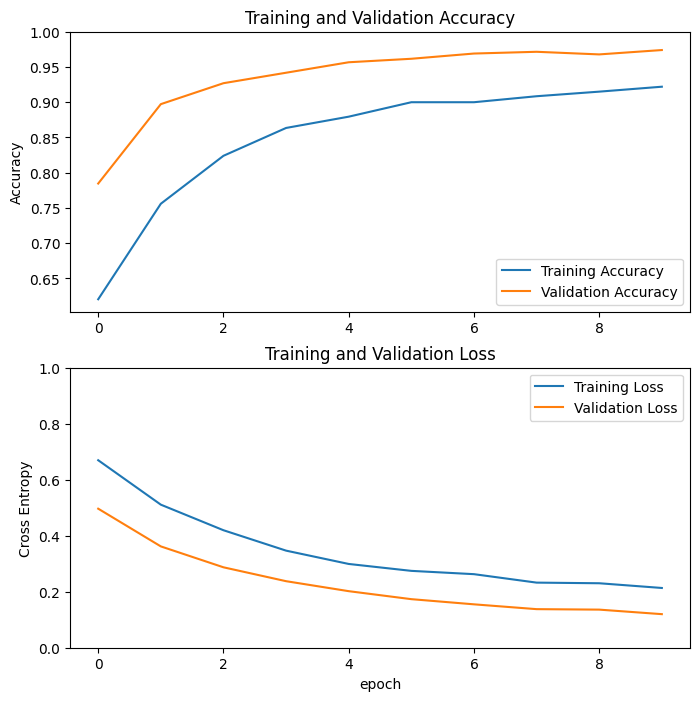

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

This was simply Transfer Learning where we didn't mess with the pretrained model at all. We can alternatively also allow some of the upper convolution layers to be trained as well. This should be done after first training the top dense layers while keeping the pretrained model frozen though since otherwise it will mess it up.

Unfreeze the top layers

In [25]:
base_model.trainable = True

In [26]:
print(f"Number of layers in the base model: {len(base_model.layers)}")

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before this layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 154


Compiling the new model. The change in the compiling is in the learning rate, which is reduced even further.

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

54 new variables added from the 54 layers that were unfrozen

In [28]:
len(model.trainable_variables)

56

Now continue training the model. We are only training 10 epochs again but since the total will be 20 we provide the initial epoch as 10 from history.epoch

In [29]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
63/63 [==============================] - 15s 94ms/step - loss: 0.1624 - accuracy: 0.9370 - val_loss: 0.0477 - val_accuracy: 0.9889
Epoch 12/20
63/63 [==============================] - 4s 59ms/step - loss: 0.1239 - accuracy: 0.9530 - val_loss: 0.0581 - val_accuracy: 0.9777
Epoch 13/20
63/63 [==============================] - 4s 59ms/step - loss: 0.1012 - accuracy: 0.9635 - val_loss: 0.0420 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 5s 72ms/step - loss: 0.1057 - accuracy: 0.9555 - val_loss: 0.0342 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 4s 58ms/step - loss: 0.0914 - accuracy: 0.9635 - val_loss: 0.0397 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 4s 58ms/step - loss: 0.0762 - accuracy: 0.9695 - val_loss: 0.0608 - val_accuracy: 0.9752
Epoch 17/20
63/63 [==============================] - 5s 73ms/step - loss: 0.0730 - accuracy: 0.9700 - val_loss: 0.0367 - val_accuracy: 0.9876
Epoch

Adding the new accuracy and losses to the previous values to graph the whole process

In [30]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Plotting the curves

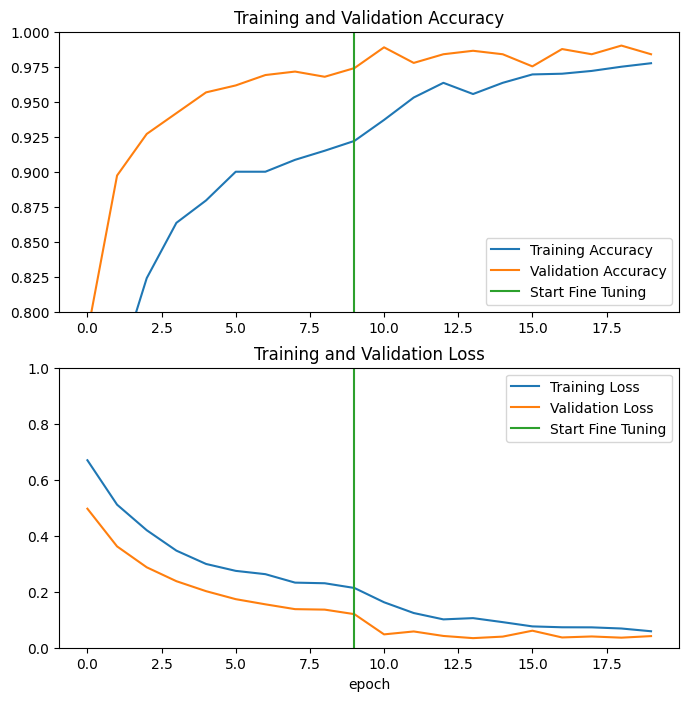

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluating on the test data

In [32]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 61ms/step - loss: 0.0270 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Visually seeing the test results

Predictions:
 [0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1]
Labels:
 [0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1]


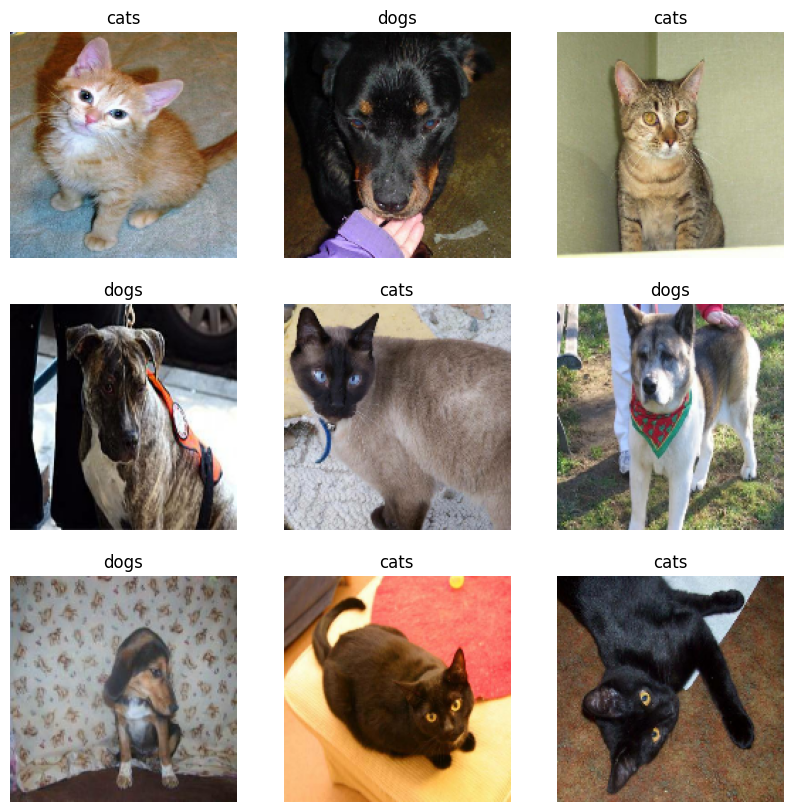

In [41]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

label_predictions = [0 if prediction < 0.5 else 1 for prediction in predictions]

print('Predictions:\n', np.array(label_predictions))
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[label_predictions[i]])
  plt.axis("off")